In [1]:
# Importing Necessary Libraries
import pandas as pd
import numpy as np
import re
import spacy
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from scipy.special import logsumexp
import random
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity

# Ensure NLTK stopwords are downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")
nltk_stopwords = set(stopwords.words('english'))  # Use NLTK stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\karti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Specify the path where the FastText model was saved
fasttext_model_path = 'final_fasttext_model.bin'

# Load the FastText model
fasttext_model = KeyedVectors.load_word2vec_format(fasttext_model_path, binary=True)

print(f"FastText model loaded from {fasttext_model_path}")

FastText model loaded from final_fasttext_model.bin


In [3]:
def load_data(filepath):
    """Load CSV data into a pandas DataFrame."""
    return pd.read_csv(filepath)

In [4]:
def remove_special_chars_and_punctuation(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

def remove_single_alphabet_tokens(text):
    return re.sub(r'\b[a-zA-Z]\b', '', text)

def remove_numerical_tokens(text):
    return re.sub(r'\b\d+\b', '', text)

def remove_alphanumeric_tokens(text):
    return re.sub(r'\b(?=.*\d)(?=.*[a-zA-Z])[a-zA-Z0-9]+\b', '', text)

def remove_pgp_key_patterns(text):
    return re.sub(r'\b(pgp|begin|end|key|public|block)\b', '', text, flags=re.IGNORECASE)

def remove_tokens_with_non_standard_characters(text):
    return re.sub(r'[^\x00-\x7F]+', '', text)

def custom_preprocessor(text):
    text = remove_special_chars_and_punctuation(text)
    text = remove_single_alphabet_tokens(text)
    text = remove_numerical_tokens(text)
    text = remove_alphanumeric_tokens(text)
    text = remove_pgp_key_patterns(text)
    text = remove_tokens_with_non_standard_characters(text)
    words = text.lower().split()
    words = [word for word in words if word not in nltk_stopwords]
    return ' '.join(words)

def extract_nouns_pronouns_and_ner(text, ner_labels=None):
    doc = nlp(text)
    
    if ner_labels is None:
        ner_labels = ['PERSON', 'NORP', 'FAC', 'ORG', 'GPE', 'LOC', 'PRODUCT', 'EVENT'] 
    
    extracted_terms = set()
    
    for token in doc:
        if token.pos_ in ['NOUN', 'PROPN'] and token.text.lower() not in nltk_stopwords:
            extracted_terms.add(token.text)
        elif token.ent_type_ in ner_labels:
            extracted_terms.add(token.text)

    processed_terms = [custom_preprocessor(term) for term in extracted_terms]
    
    return ' '.join([term for term in processed_terms if term.strip()])

In [5]:
def preprocess_data(df, text_column):
    """Apply preprocessing and extraction to the specified text column."""
    # Apply the extraction and preprocessing step
    df['processed_text'] = df[text_column].fillna('').apply(lambda x: extract_nouns_pronouns_and_ner(str(x)))

    # Remove rows where 'processed_text' is empty after preprocessing
    df = df[df['processed_text'].str.strip() != '']
    
    return df

In [6]:
def vectorize_text(df, text_column):
    """Convert processed text to word count vectors using CountVectorizer."""
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df[text_column])
    vocab = vectorizer.vocabulary_
    return X, vocab, vectorizer

def create_corpus(X):
    """Convert the document-term matrix into a corpus of word IDs."""
    return [doc.nonzero()[1].tolist() for doc in X]


In [7]:
def compute_document_frequency(corpus):
    """Compute document frequency for each word in the corpus."""
    df = defaultdict(int)
    for document in corpus:
        unique_words = set(document)
        for word in unique_words:
            df[word] += 1
    return df

def compute_word_influence(df_counts, N, lambda_factor=2, epsilon=1e-5):
    """Compute word influence (dynamic weighting) with lambda factor."""
    word_influence = {word: lambda_factor * np.log((N + epsilon) / (1 + count)) for word, count in df_counts.items()}
    return word_influence

def get_word_influence_array(word_influence, V):
    """Convert word_influence dictionary to array."""
    word_influence_array = np.zeros(V)
    for word, influence in word_influence.items():
        word_influence_array[word] = influence
    return word_influence_array

def compute_beta_w(beta, word_influence_array):
    """Compute per-word beta values."""
    beta_w = beta * word_influence_array
    beta_sum = np.sum(beta_w)
    return beta_w, beta_sum


In [8]:
def initialize_lda(corpus, K, V, alpha):
    """Initialize count matrices and topic assignments for LDA."""
    D = len(corpus)
    n_d_k = np.zeros((D, K), dtype=np.int32)
    n_k_w = np.zeros((K, V), dtype=np.int32)
    n_k = np.zeros(K, dtype=np.int32)

    topic_assignments = []
    for d, doc in enumerate(corpus):
        current_doc_topics = np.zeros(len(doc), dtype=np.int32)
        for i, word in enumerate(doc):
            topic = np.random.randint(0, K)
            current_doc_topics[i] = topic
            n_d_k[d, topic] += 1
            n_k_w[topic, word] += 1
            n_k[topic] += 1
        topic_assignments.append(current_doc_topics)
    return n_d_k, n_k_w, n_k, topic_assignments


In [9]:
def gibbs_sampling(corpus, K, V, alpha, beta, iterations, beta_w, beta_sum, n_d_k, n_k_w, n_k, topic_assignments):
    """Perform Gibbs sampling for LDA with dynamic word influence."""
    D = len(corpus)
    for it in range(iterations):
        for d, doc in enumerate(corpus):
            for i, word in enumerate(doc):
                current_topic = topic_assignments[d][i]
                n_d_k[d, current_topic] -= 1
                n_k_w[current_topic, word] -= 1
                n_k[current_topic] -= 1

                denominator = n_k + beta_sum + 1e-10
                log_topic_probs = (
                    np.log(n_d_k[d, :] + alpha) +
                    np.log(n_k_w[:, word] + beta_w[word]) -
                    np.log(denominator)
                )

                # Use logsumexp for numerically stable log probability calculations
                topic_probs = np.exp(log_topic_probs - logsumexp(log_topic_probs))

                new_topic = np.random.choice(K, p=topic_probs)
                topic_assignments[d][i] = new_topic
                n_d_k[d, new_topic] += 1
                n_k_w[new_topic, word] += 1
                n_k[new_topic] += 1
    return n_d_k, n_k_w, n_k, topic_assignments


In [10]:
def compute_phi(n_k_w, beta_w, n_k, beta_sum):
    """Compute topic-word distribution phi."""
    return (n_k_w + beta_w[np.newaxis, :]) / (n_k[:, np.newaxis] + beta_sum)

def compute_theta(n_d_k, alpha, K):
    """Compute document-topic distribution theta."""
    return (n_d_k + alpha) / (np.sum(n_d_k, axis=1)[:, np.newaxis] + K * alpha)


In [11]:
def compute_topic_diversity(topics, num_top_words=30):
    """Compute topic diversity score based on the uniqueness of top words."""
    # Collect all the top words from each topic
    top_words = set()
    total_words = 0

    for topic in topics:
        total_words += num_top_words
        top_words.update(topic[:num_top_words])

    # Topic diversity is the ratio of unique words to the total number of top words
    return len(top_words) / total_words if total_words > 0 else 0


In [12]:
def compute_iwec_scores(topics, fasttext_model, num_top_words=10):
    """Compute IWEC scores for the given topics."""
    iwec_scores = []
    for words in topics:
        # Select top N words
        words = words[:num_top_words]
        # Retrieve embeddings for the words
        embeddings = []
        for word in words:
            try:
                embeddings.append(fasttext_model[word])
            except KeyError:
                # Handle OOV words if any
                embeddings.append(np.zeros(fasttext_model.vector_size))
        if len(embeddings) < 2:
            coherence = 0.0
        else:
            similarities = cosine_similarity(embeddings)
            idx_upper = np.triu_indices_from(similarities, k=1)
            coherence = np.mean(similarities[idx_upper])
        iwec_scores.append(coherence)
    return iwec_scores


In [13]:
def print_top_words(phi, vocab, num_top_words=30):
    """Print the top words for each topic."""
    inv_vocab = {v: k for k, v in vocab.items()}
    for topic_idx, topic in enumerate(phi):
        top_word_indices = topic.argsort()[::-1][:num_top_words]
        top_words = [inv_vocab[i] for i in top_word_indices]
        print(f"Topic {topic_idx + 1}: {' '.join(top_words)}")

def save_top_words_combined(topics, year, filename='modified_lda_noun_ner.txt'):
    with open(filename, 'a') as f:
        f.write(f"Year: {year}\n")
        f.write("=" * 40 + "\n")
        for idx, topic_words in enumerate(topics):
            f.write(f"Topic {idx + 1}:\n")
            f.write(' '.join(topic_words) + '\n\n')
        f.write("\n\n")
    print(f"Top words for each topic saved for year {year} into {filename}.")

def get_topics(phi, inv_vocab, num_top_words=30):
    """Extract the top words for each topic."""
    topics = []
    for topic_idx, topic in enumerate(phi):
        top_word_indices = topic.argsort()[::-1][:num_top_words]
        top_words = [inv_vocab[i] for i in top_word_indices]
        topics.append(top_words)
    return topics


In [14]:
def run_lda_per_year(filepath, text_column, year_column, K=5, alpha=0.5, beta=0.005, iterations=1000, lambda_factor=2):
    """Run the LDA process with dynamic word influence for each year in the dataset."""
    df = load_data(filepath)
    
    # Preprocess the data before LDA processing
    df = preprocess_data(df, text_column)
    
    # Extract unique years from the year_column
    unique_years = df[year_column].unique()

    results_by_year = {}

    total_docs = 0
    weighted_diversity = 0
    overall_weighted_iwec = 0

    for year in sorted(unique_years):
        print(f"Processing year: {year}")
        
        # Filter the dataframe by the current year
        df_year = df[df[year_column] == year]
        
        # Vectorize text for the specific year
        X, vocab, vectorizer = vectorize_text(df_year, 'processed_text')
        corpus = create_corpus(X)
        V = len(vocab)

        # Compute word influence
        df_counts = compute_document_frequency(corpus)
        N = len(corpus)
        word_influence = compute_word_influence(df_counts, N, lambda_factor)

        word_influence_array = get_word_influence_array(word_influence, V)

        beta_w, beta_sum = compute_beta_w(beta, word_influence_array)

        # Initialize LDA
        n_d_k, n_k_w, n_k, topic_assignments = initialize_lda(corpus, K, V, alpha)

        # Perform Gibbs Sampling
        n_d_k, n_k_w, n_k, topic_assignments = gibbs_sampling(
            corpus, K, V, alpha, beta, iterations, beta_w, beta_sum, n_d_k, n_k_w, n_k, topic_assignments
        )

        # Compute distributions
        phi = compute_phi(n_k_w, beta_w, n_k, beta_sum)
        theta = compute_theta(n_d_k, alpha, K)

        # Invert vocabulary
        inv_vocab = {v: k for k, v in vocab.items()}

        # Get topics
        topics = get_topics(phi, inv_vocab, num_top_words=30)

        # Compute topic diversity
        topic_diversity_score = compute_topic_diversity(topics, num_top_words=30)

        # Compute IWEC scores
        iwec_scores = compute_iwec_scores(topics, fasttext_model, num_top_words=10)

        # Compute weighted average IWEC score for the year
        # Get topic proportions from theta
        topic_proportions = np.sum(theta, axis=0)
        total_topic_weight = np.sum(topic_proportions)
        topic_proportions_normalized = topic_proportions / total_topic_weight

        weighted_iwec_score = np.dot(iwec_scores, topic_proportions_normalized)

        num_documents = len(df_year)
        total_docs += num_documents
        weighted_diversity += topic_diversity_score * num_documents
        overall_weighted_iwec += weighted_iwec_score * num_documents

        # Store results for the current year
        results_by_year[year] = {
            "phi": phi,
            "theta": theta,
            "vocab": vocab,
            "vectorizer": vectorizer,
            "topic_diversity_score": topic_diversity_score,
            "weighted_iwec_score": weighted_iwec_score,
            "num_documents": num_documents
        }

        # Print the top words for each topic in this year
        print(f"Top words for year {year}:")
        print_top_words(phi, vocab)

        # Save top words to a text file
        save_top_words_combined(topics, year, filename='modified_lda_noun_ner.txt')

        print(f"Year {year}: Topic Diversity Score = {topic_diversity_score:.4f}, Weighted IWEC Score = {weighted_iwec_score:.4f}")

    # Compute final weighted averages
    avg_weighted_diversity = weighted_diversity / total_docs
    avg_weighted_iwec = overall_weighted_iwec / total_docs

    return results_by_year, avg_weighted_diversity, avg_weighted_iwec

In [15]:
# Filepath and text column
filepath = 'cleaned_english_posts.csv'
text_column = 'post_content'
year_column = 'year'

# Adjust hyperparameters
K = 10             # Number of topics (consistent with previous models)
alpha = 0.5       # Document-topic distribution prior
beta = 0.1        # Increased beta to enhance beta_w effect
iterations = 100  # Number of Gibbs sampling iterations
lambda_factor = 10  # Adjusted lambda_factor for significant scaling

# Run the LDA model with dynamic word influence for each year
results_by_year, avg_weighted_diversity, avg_weighted_iwec = run_lda_per_year(
    filepath, text_column, year_column, K, alpha, beta, iterations, lambda_factor
)

print(f"Weighted Average Topic Diversity Score Across Years: {avg_weighted_diversity:.4f}")
print(f"Overall Weighted Average IWEC Score Across Years: {avg_weighted_iwec:.4f}")

Processing year: 2018
Top words for year 2018:
Topic 1: dread people time hugbunter site market post users vendors way page community reddit vendor user onion sub information dream markets message thing security service scam account others link reason list
Topic 2: posts threads one subdread thanks services spam ip lean fraudescobay shipments border ui unintresting shippingif bottles hindu oz kush sheet blocking shatter gang urlsregistration division bitmessage uspis format rd foreverrules
Topic 3: order couple state market member home retards harmreduction step powers lives courts hashes vehicles becuase potentcy prick growshrooms luck subforums background growcannabis obituary aviation nvidia volume speedsteppers authenticity troll darknetmarketsindia
Topic 4: activity login zpower vendingon bka hanting listthanks berlusconimarket dpr opnion bee opinions cheers lose openpgp culture cryptonia donation onionescobaydrqxdidzg impurity vibrators imho hashtag viewany drugmanufacture follow

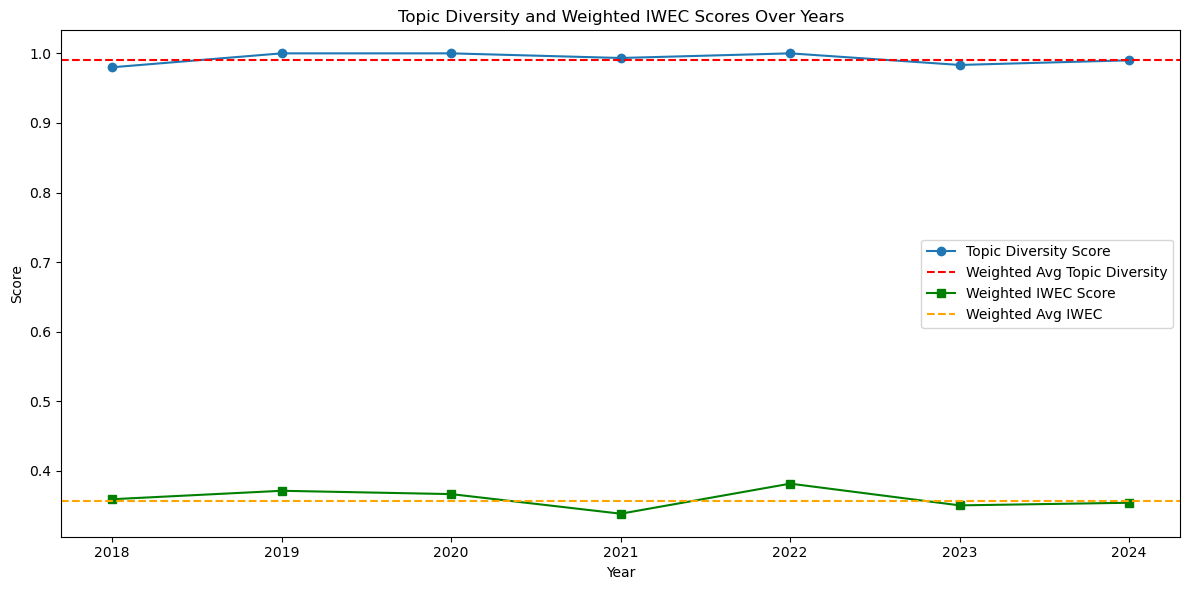

In [16]:
years = []
topic_diversity_scores = []
iwec_scores_per_year = []
num_docs_per_year = []

for year in sorted(results_by_year.keys()):
    years.append(year)
    topic_diversity_scores.append(results_by_year[year]['topic_diversity_score'])
    iwec_scores_per_year.append(results_by_year[year]['weighted_iwec_score'])
    num_docs_per_year.append(results_by_year[year]['num_documents'])

plt.figure(figsize=(12, 6))

plt.plot(years, topic_diversity_scores, marker='o', label='Topic Diversity Score')
plt.axhline(y=avg_weighted_diversity, color='r', linestyle='--', label='Weighted Avg Topic Diversity')

plt.plot(years, iwec_scores_per_year, marker='s', color='green', label='Weighted IWEC Score')
plt.axhline(y=avg_weighted_iwec, color='orange', linestyle='--', label='Weighted Avg IWEC')

plt.title('Topic Diversity and Weighted IWEC Scores Over Years')
plt.xlabel('Year')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()
